# Inverse dynamics optimization on real data
- This notebook is dedicated to testing the optimization process for inverse dynamics 
- Starting from a rough solution estimated by inverse kinematics
- No consideration of 2 projections is considered here (at least yet!)

:+1: Process either real or simulated data

In [1]:
import time 

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pinocchio as pin
from scipy.optimize import least_squares
from scipy.special import huber
from projectyl.utils.properties import ELBOW, SHOULDER, WRIST
from projectyl.utils.arm import plot_optimization_curves

from projectyl.dynamics.inverse_kinematics import build_arm_model
from projectyl.utils.arm import interactive_replay_sequence
from projectyl.utils.io import Dump
from projectyl.dynamics.inverse_dynamics import objective
from projectyl.dynamics.simulation import build_simulation
SIMULATION = "simulation"
REAL = "real"

%load_ext autoreload
%autoreload 2
global_params = {}


# :warning: PICK **REAL** or **SIMULATION**

In [2]:
# PICK UP THE MODE HERE
# mode = SIMULATION
mode = REAL
assert mode in [SIMULATION, REAL]

build_arm_model(global_params, headless=False, free_elbow=True if mode == SIMULATION else False)
arm_robot = global_params["arm"]
viz = global_params["viz"]

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


# SIMULATION


In [3]:
T=30
if mode == SIMULATION:
    # T_ORIGINAL = 30*3
    DT = 1E-2
    gt_q, gt_vq, gt_aq, gt_tauq, gt_shoulder_p, gt_elbow_p, gt_wrist_p = build_simulation(
        arm_robot,
        initial_torque_modulation=1.,
        T=T,
        DT=DT,
        friction_coefficient=0.01)

    # We will feed the optimiser with the following parameters
    # ground_truth_p = [p_shoulder_1, p_elbow_1, p_wrist_1, ..., p_shoulder_T, p_elbow_T, p_wrist_T], T and nq
    # The optimisation variable is
    # [q_1, q_2, ..., q_T, tauq_3, tauq_4, ..., tauq_T-2]

    gt_p = np.concatenate([
        np.concatenate([
            gt_shoulder_p[i], gt_elbow_p[i], gt_wrist_p[i]]
        ) for i in range(T)]
    )
    gt_qt = np.concatenate(gt_q + gt_tauq[2:-2])
    initial = gt_qt.flatten()
    gt_full = np.concatenate([gt_q, gt_tauq], axis=1)

# REAL DATA
### Load data


To load data, you need a preprocessed video file. Assume IK has been performed first.

`python scripts/batch_video_processing.py -i "data/*9_*.mp4" -o __out -A ik --headless`

In [12]:
T = 30
if mode == REAL:
    data = Dump.load_pickle("../__out/0009_weight_lifting_main_camera_30fps/coarse_ik.pkl")

    # INITIAL STATE LIST
    q = np.array(data["q"])
    if T is None:
        T = len(q)

    # 3D points
    p = ([np.array([el.translation for el in data["3dpoints"][member]]).T for member in [SHOULDER, ELBOW, WRIST]])
    print(p[0].shape)
    gt_p_full = np.concatenate(p).T
    gt_p_full = gt_p_full[:T]
    print("Final shape", gt_p_full.shape) #T, 9

    # initialization from IK estimation
    initial_full = np.concatenate([q[:T].flatten(), np.zeros(((T-4), 4)).flatten()])
    initial_full.shape
    DT = 1/30. # 30fps
    print(initial_full.shape)
    initial = initial_full.flatten()
    gt_p = gt_p_full.flatten()
    init_res = np.concatenate([q[:T], np.zeros((T, 4))], axis=1) # For plots

(3, 468)
Final shape (30, 9)
(254,)


# OPTIMIZE

In [5]:
debug= False
_sol = least_squares(objective, initial.flatten(), args=(gt_p, T, DT, arm_robot), kwargs={"debug": debug}, method='lm').x
sol = _sol.copy()

In [6]:
# Extract the results
# First extract the T * nq configuration states
res_q = sol.copy()[:T*arm_robot.model.nq].reshape(T, -1)
q_norm = np.linalg.norm(res_q[:, :4], axis=1)
res_q[:, :4]/= q_norm.reshape(-1, 1)
# Extract the (T-4) * nv torque states
res_tauq = sol.copy()[T*arm_robot.model.nq:].reshape((T-4), -1)
# Concatenate the two
res_tauq = np.concatenate([np.zeros((2, arm_robot.model.nv)), res_tauq, np.zeros((2, arm_robot.model.nv))], axis=0)
res_q.shape, res_tauq.shape
estimated_results = np.concatenate([res_q, res_tauq], axis=1)

(30,)


In [7]:
# Check the errors
print(">>>>>>> Initial error", np.linalg.norm(objective(initial, gt_p, T, DT, arm_robot, True)))
print(">>>>>>> Optimization error", np.linalg.norm(objective(sol, gt_p, T, DT, arm_robot, True)))

30, 0.03333333333333333, var = (254,), observed_p = (270,)
Diff between 3D pose : 0.1583317497517157
Smooth velocity : 4.688951373629895
Smooth acceleration : 55.611910007619244
Smooth torque : 0.0
Dynamics : 16.732085613988666
>>>>>>> Initial error 47.340863033991006
30, 0.03333333333333333, var = (254,), observed_p = (270,)
Diff between 3D pose : 1.1501521640357188
Smooth velocity : 0.37008581700057025
Smooth acceleration : 0.15839282289702994
Smooth torque : 0.3449046193239304
Dynamics : 0.03104140992484155
>>>>>>> Optimization error 1.1949344061730698


# Plot curves

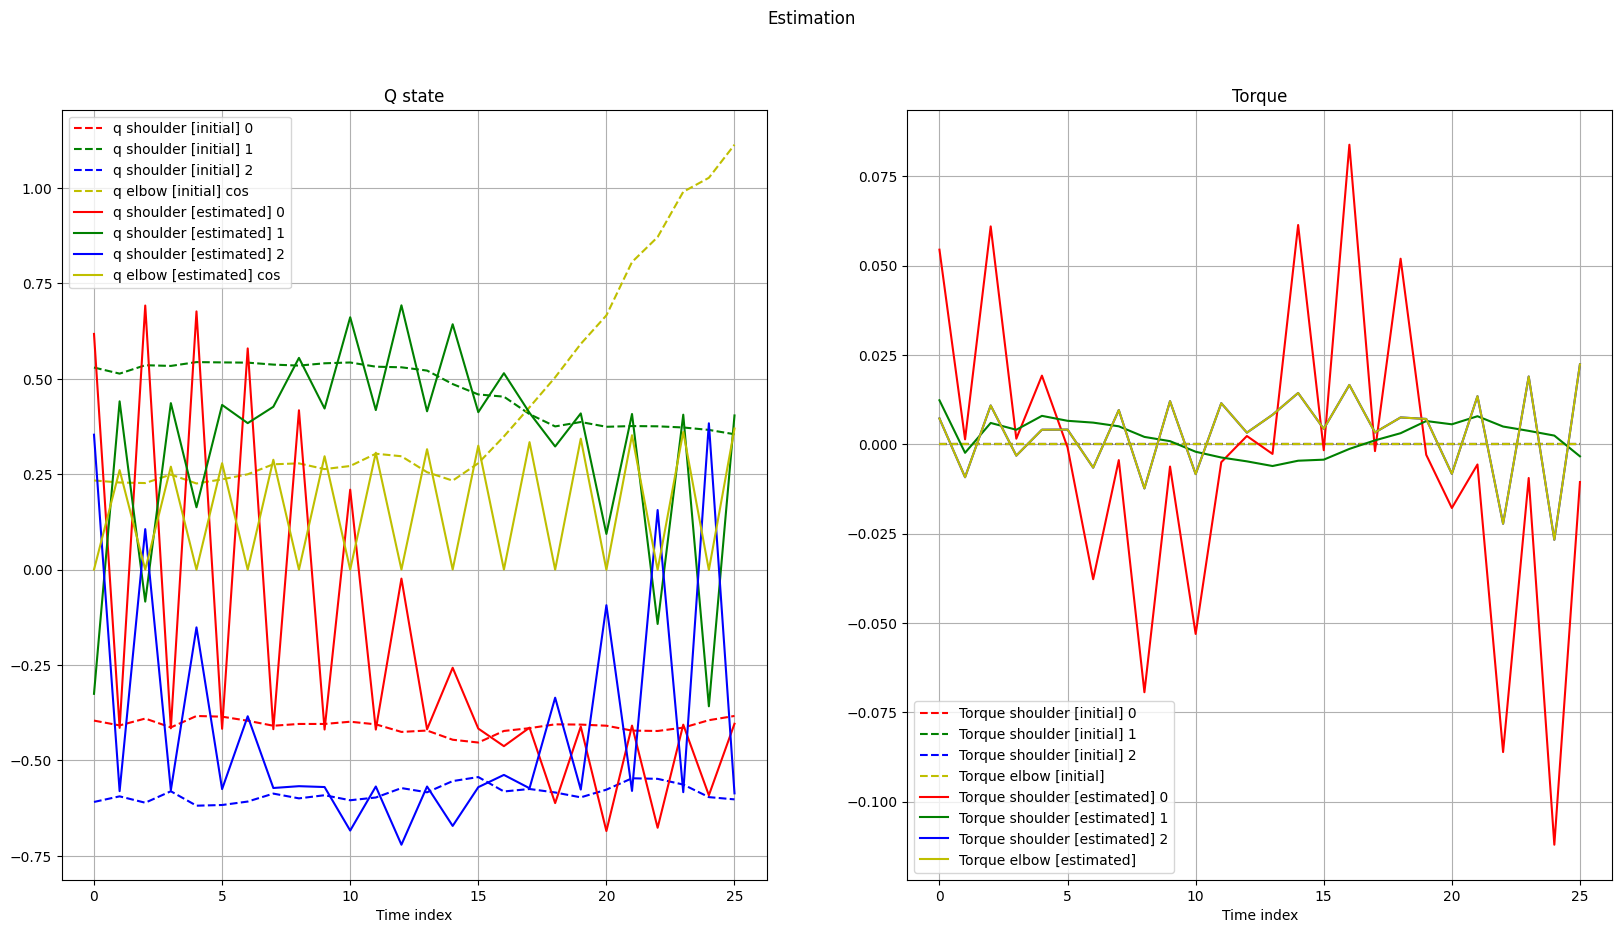

In [11]:
from interactive_pipe.helper import _private
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.
plot_optimization_curves([
    (init_res[2:-2, :], "[initial]", "--"),
    (estimated_results[2:-2, :], "[estimated]", "-"),
    # (gt_full[2:-2, :], "[groundtruth]", "-"),
    ],
    arm_robot.model.nq,
    title="Estimation",
    mode="qt",
    fig_size=10
)
if mode == SIMULATION:
    plot_optimization_curves([
        # (estimated_results[2:-2, :], "[estimated]", "--"),
        (gt_full[2:-2, :], "[groundtruth]", "-"),
        ],
        arm_robot.model.nq,
        title="Groundtruth",
        mode="qt",
        fig_size=10
    )

# Replay the motion interactively

In [ ]:
interactive_replay_sequence(
    {
        "estimated": estimated_results[:, :arm_robot.model.nq],
        "ground truth": gt_full[:, :arm_robot.model.nq],
    },
    viz
)